In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import re

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel
from gensim.models.nmf import Nmf

from collections import OrderedDict

In [2]:
data_file = "./dreaddit/dreaddit-train-allTexts.csv"
train_df = pd.read_csv(data_file)
train_df.head()
print(train_df.shape)

(2838, 3)


## EDA

In [3]:
# How many human annotated topics are in the data?
stress_topics = list(set(train_df['subreddit'].tolist()))
print("Number of stress topics in the data: {}".format(len(stress_topics)))

Number of stress topics in the data: 10


In [4]:
# the shape of the data: how many tweets are in the data set?
print("Shape of the data: {}".format(train_df.shape))

Shape of the data: (2838, 3)


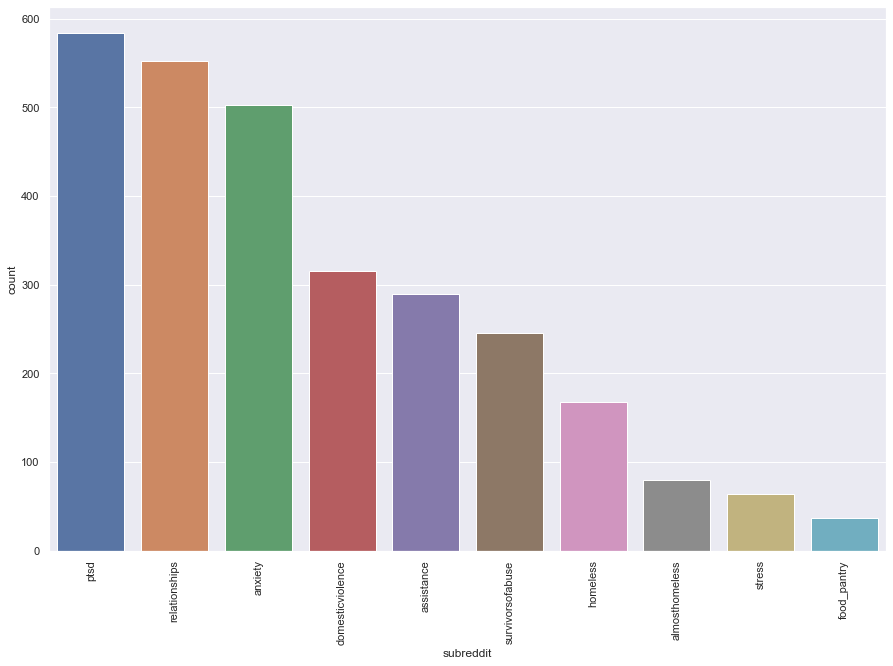

In [5]:
# the distributions of stress topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='subreddit', data=train_df, order = train_df['subreddit'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

Because some subreddits are more or less popular, the amount of data in each domain varies. We include ten total subreddits from five domains in our dataset. 

In [6]:
def getDomainsfromTopics(topic):
    if topic in ['domesticviolence', 'survivorsofabuse']:
        return 'abuse'
    elif topic in ['anxiety', 'stress']:
        return 'anxiety'
    elif topic in ['almosthomeless', 'assistance', 'food_pantry', 'homeless']:
        return 'financial'
    elif topic == 'ptsd':
        return 'PTSD'
    elif topic == 'relationships':
        return 'social'

train_df['domains'] = train_df.apply(lambda x: getDomainsfromTopics(x.subreddit), axis=1)
train_df.head()

,subreddit,text,sentiment,domains
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse


In [7]:
# How many stress domains are in the data now?
stress_domains = list(set(train_df['domains'].tolist()))
print("Number of stress domains in the data: {}".format(len(stress_domains)))

Number of stress domains in the data: 5


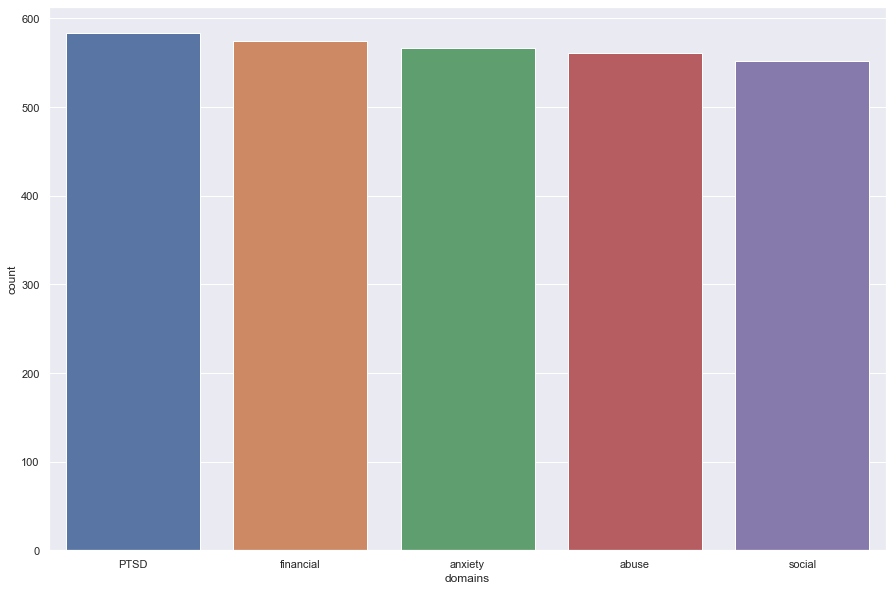

In [8]:
# the distributions of stress domains in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_domain = sns.countplot(x='domains', data=train_df, order = train_df['domains'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [9]:
def getSentiLabelFromScores(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
train_df['senti_label'] = train_df.apply(lambda x: getSentiLabelFromScores(x.sentiment), axis=1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


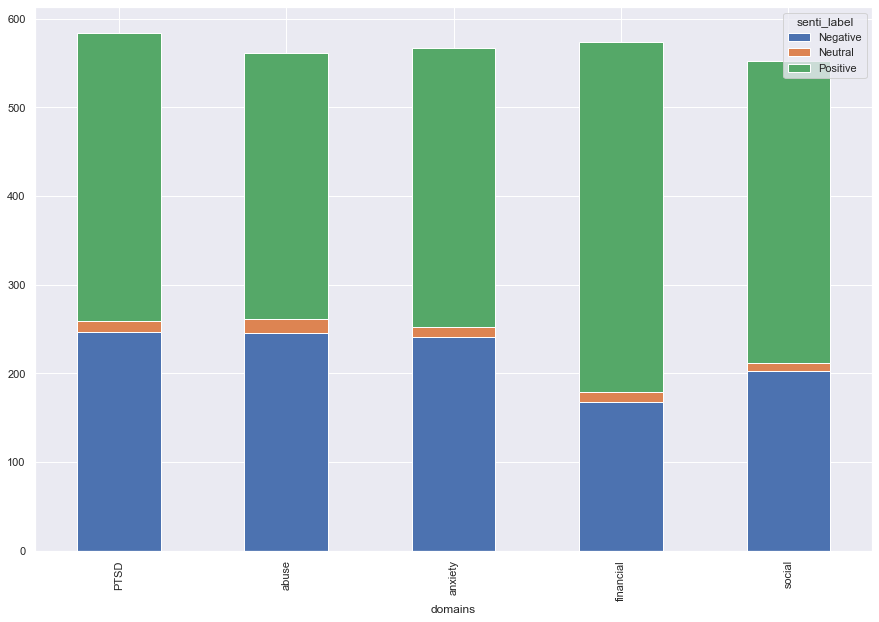

In [10]:
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

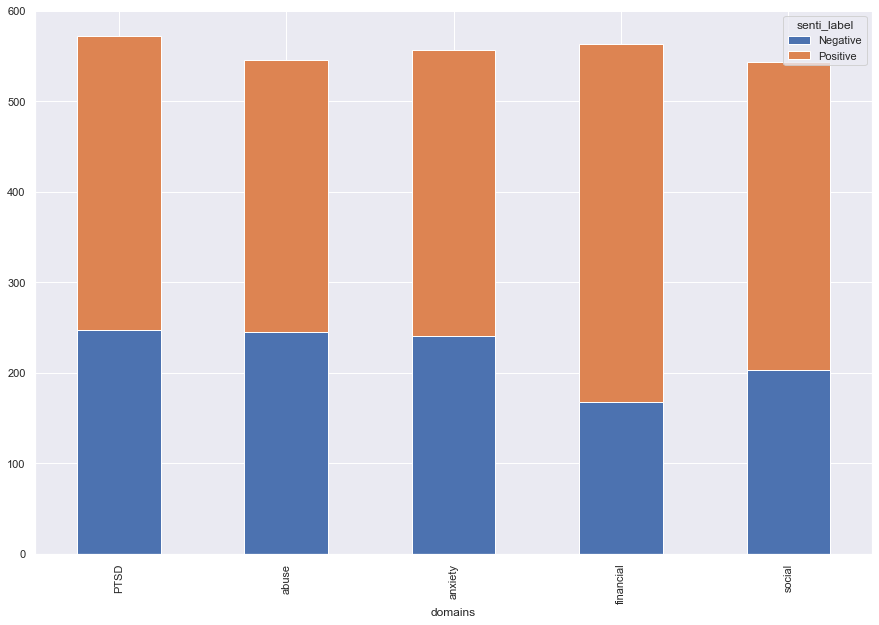

In [11]:
# drop Neutral rows since there are too few records
train_df = train_df.loc[train_df.senti_label != 'Neutral']
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

In [12]:
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


## Model

In [13]:
# Prepare the corpus for analysis
def preprocess_text(text, stem=False):
    """Preprocess one sentence: tokenizes, lowercases, applies the Porter stemmer,
     removes punctuation tokens and stopwords.
     Returns a list of strings."""
    toks = word_tokenize(text)
    # clean
    stops = stopwords.words('english')
    selfdefined_stops = ["n't", "the", "it", "get", "got", "gets", 
                         "my", "also", "one", "could", "would", "can", 
                         "as", "said", "go", "goes", "going", "went", 
                         "also", "is", "since", "these", "so", "really", 
                         "much", "what", "the", "still", "every", "any", 
                         "it", "make", "but" , "my", "like", "know", 
                         "something", "even", "tell", "told", "things", 
                         "feel", "want", "think", "take", "back", "never", 
                         "first", "last", "ca", "us", "thing", "always", 
                         "made", "else", "dont", "im", "find", "though", 
                         "let", "way", "come", "ever", "lot", "good", "bad", 
                         "maybe", "two", "little", "start", "try", "apprarently", 
                         "joe", "seem", "give", "please", "next", "able", "put", 
                         "although", "etc", "long", "url", "say", "see", "sometimes",
                         "around", "another", "bit", "x200b", "edit"]
    stopwords_list = stops + selfdefined_stops
    # stem
    if stem:
        stemmer = PorterStemmer()
        toks = [stemmer.stem(tok) for tok in toks]
    toks = [manual_stem(tok) for tok in toks]
    # remove punctuation
    toks_nopunc = [tok.lower() for tok in toks if tok not in string.punctuation]
    # remove stopwords
    toks_nostop = [tok for tok in toks_nopunc if tok not in stopwords_list]
    toks_tidy = [tok for tok in toks_nostop if re.match(r'[a-zA-Z]+', tok) and len(tok) >= 3]
    return toks_tidy

In [14]:
def manual_stem(tok):
    if tok in ['trying', 'tried', 'tries']:
        return 'try'
    if tok in ['getting', 'got', 'gets']:
        return 'get'
    if tok in ['made', 'making', 'makes']:
        return 'make'
    if tok in ['took', 'taking', 'takes']:
        return 'take'
    if tok in ['wanted', 'wants']:
        return 'want'
    if tok in ['goes', 'went', 'going']:
        return 'go'
    if tok in ['told', 'telling', 'tells']:
        return 'tell'
    if tok in ['feeling', 'felt', 'feels', 'feelings']:
        return 'feel'
    if tok in ['found', 'finds']:
        return 'find'
    if tok in ['asked', 'askes', 'asking']:
        return 'ask'
    if tok in ['seems', 'seemed']:
        return 'seem'
    if tok in ['working', 'worked', 'works']:
        return 'work'
    if tok in ['strating', 'started', 'starts']:
        return 'start'
    if tok in ['coming', 'came', 'comes']:
        return 'come'
    if tok in ['best', 'well']:
        return 'good'
    if tok in ['called', 'calls']:
        return 'call'
    if tok in ['thinking', 'thought', 'thinks']:
        return 'think'
    if tok in ['trying', 'tried', 'trys']:
        return 'try'
    if tok == 'years':
        return 'year'
    if tok == 'months':
        return 'month'
    if tok == 'days':
        return 'day'
    if tok == 'friends':
        return 'friend'
    if tok == 'thanks':
        return 'thank'
    if tok == 'jobs':
        return 'job'
    else:
        return tok

In [15]:
train_df['text'] = train_df.apply(lambda x: preprocess_text(x.text), axis = 1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"[suggeted, rest, trigger, ahead, youi, hypocon...",-0.002742,PTSD,Negative
1,assistance,"[hey, r/assistance, sure, right, place, post, ...",0.292857,financial,Positive
2,ptsd,"[mom, hit, newspaper, shocked, knows, play, hi...",0.011894,PTSD,Positive
3,relationships,"[met, new, boyfriend, amazing, kind, sweet, st...",0.141671,social,Positive
4,survivorsofabuse,"[october, domestic, violence, awareness, month...",-0.204167,abuse,Negative


In [16]:
texts = train_df['text']
dictionary = corpora.Dictionary(texts)
print(dictionary.token2id)

{'age': 0, 'ahead': 1, 'ailments': 2, 'b.s.': 3, 'conspiracy': 4, 'decide': 5, 'doom': 6, 'ended': 7, 'gloom': 8, 'happen': 9, 'health': 10, 'heart': 11, 'hole': 12, 'hopes': 13, 'hours': 14, 'hypocondriac': 15, 'indicative': 16, 'laugh': 17, 'look': 18, 'ludicrous': 19, 'new': 20, 'physical': 21, 'prone': 22, 'psychic': 23, 'rabbit': 24, 'reading': 25, 'rest': 26, 'road': 27, 'sense': 28, 'stupid': 29, 'sucked': 30, 'suggeted': 31, 'test': 32, 'top': 33, 'trigger': 34, 'various': 35, 'worried': 36, 'youi': 37, 'along': 38, 'amazon': 39, 'appreciate': 40, 'chance': 41, 'country': 42, 'current': 43, 'currently': 44, 'drawing': 45, 'efforts': 46, 'entered': 47, 'everyone': 48, 'gcs': 49, 'greatly': 50, 'help': 51, 'helps': 52, 'hey': 53, 'improve': 54, 'intern': 55, 'labs': 56, 'looking': 57, 'many': 58, 'marketing': 59, 'national': 60, 'outreach': 61, 'pass': 62, 'place': 63, 'post': 64, 'r/assistance': 65, 'recruit': 66, 'right': 67, 'sandia': 68, 'schools': 69, 'short': 70, 'stem': 71

In [17]:
# A major question in using LDA for topic modeling is what is is the proper set of
# hyperparmeters to generate the optimal set of topics for the coprus of documents
# under examination. Gensim includes methods for computing the Perplexity and Topic 
# Coherence of a corpus. One appraoch is to sample an LDA model for a range of 
# for perplexity and topic coherence and select the appropriate number of topics
# from a point of minimum perplexity and maximium topic coherence.

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, 
# and even sometimes slightly anti-correlated.
# So only using coherence score to evaluate models in our project
# perplexity_lda = []
coherence_lda = []
topic_count_lda = []

for num_topics in range(2, 16, 1):
    
    print("Computing the lda model using {} topics".format(num_topics))
    
    topic_lda = models.LdaModel(corpus,
                                id2word = dictionary,
                                num_topics = num_topics,
                                iterations = 1000,
                                alpha = 'auto')
    corpus_lda = topic_lda[corpus] # Use the bow corpus
    
    topic_count_lda.append(num_topics)
    
#     # a measure of how good the model is. the lower, the better.
#     perplexity_lda.append(topic_lda.log_perplexity(corpus))

    # Compute Coherence Score
    cm = CoherenceModel(model=topic_lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence_lda.append(cm.get_coherence())

Computing the lda model using 2 topics
Computing the lda model using 3 topics
Computing the lda model using 4 topics
Computing the lda model using 5 topics
Computing the lda model using 6 topics
Computing the lda model using 7 topics
Computing the lda model using 8 topics
Computing the lda model using 9 topics
Computing the lda model using 10 topics
Computing the lda model using 11 topics
Computing the lda model using 12 topics
Computing the lda model using 13 topics
Computing the lda model using 14 topics
Computing the lda model using 15 topics


In [18]:
# Pull the resulting data into a pandas dataframe
topics_lda = pd.DataFrame({'coherence': coherence_lda},
                         index = topic_count_lda)

topics_lda

,coherence
2,-2.983858
3,-2.450588
4,-2.671820
5,-2.800051
6,-2.628349
7,-2.996381
8,-2.761876
9,-2.958775
10,-3.357484
11,-3.325598


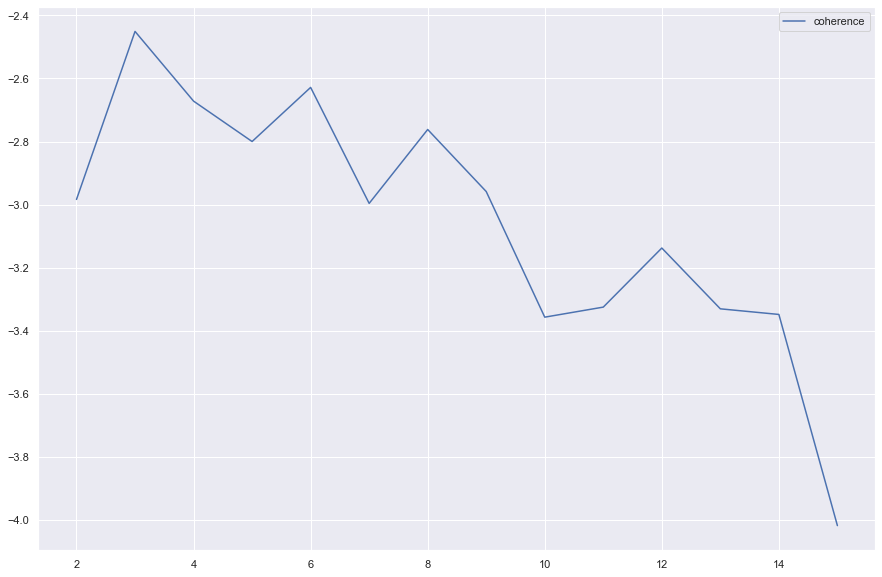

In [19]:
lines = topics_lda.plot.line()
# the higher the better

In [30]:
# Gensim LDA stores all the text for processing into a corpus object
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
# the higest coherence
total_topics = 3

# lda model
lda_model = models.LdaModel(corpus, id2word = dictionary, num_topics = total_topics, iterations = 1000, alpha='auto')
# Show first n=10 important words in the topics:
lda_model.show_topics(total_topics, 10)

[(0,
  '0.008*"help" + 0.008*"year" + 0.007*"time" + 0.007*"work" + 0.006*"job" + 0.005*"people" + 0.005*"day" + 0.005*"need" + 0.004*"ask" + 0.004*"family"'),
 (1,
  '0.008*"year" + 0.007*"people" + 0.006*"work" + 0.006*"life" + 0.006*"anxiety" + 0.005*"time" + 0.005*"month" + 0.005*"help" + 0.005*"need" + 0.005*"friend"'),
 (2,
  '0.012*"time" + 0.008*"friend" + 0.008*"day" + 0.007*"year" + 0.006*"work" + 0.005*"life" + 0.005*"ask" + 0.004*"help" + 0.004*"month" + 0.004*"relationship"')]

In [31]:
# Load the topic - term data into an python dictionary
data_lda_model = {i: OrderedDict(lda_model.show_topic(i,10)) for i in range(total_topics)}
data_lda_model

{0: OrderedDict([('help', 0.00845534),
              ('year', 0.0075185625),
              ('time', 0.0072562727),
              ('work', 0.0067158784),
              ('job', 0.005957954),
              ('people', 0.005448985),
              ('day', 0.005218177),
              ('need', 0.004571033),
              ('ask', 0.0043311077),
              ('family', 0.0039586215)]),
 1: OrderedDict([('year', 0.0075849025),
              ('people', 0.0070335977),
              ('work', 0.0064857947),
              ('life', 0.006008394),
              ('anxiety', 0.005616431),
              ('time', 0.0052177855),
              ('month', 0.005087332),
              ('help', 0.0048181918),
              ('need', 0.004699206),
              ('friend', 0.0045782337)]),
 2: OrderedDict([('time', 0.011681742),
              ('friend', 0.008019003),
              ('day', 0.007972237),
              ('year', 0.006697074),
              ('work', 0.006024013),
              ('life', 0.004626395),
     

In [32]:
# infer the distribution of topics according to the lda model
topics = []
probs = []
max_to_show = 10

for k, i in enumerate(range(len(texts))):
    try:
        bow = dictionary.doc2bow(texts[i])
        doc_topics = lda_model.get_document_topics(bow, minimum_probability = 0.01)
        # topic with the highest probability
        topics_sorted = sorted(doc_topics, key = lambda x: x[0], reverse = True)
        topics.append(topics_sorted[0][0])
        probs.append("{}".format(topics_sorted[0][1]))

        # Dump out the topic and probability assignments for the first 20 texts
        if k < max_to_show:
            print("Text {}: {}".format(k, topics_sorted))
    except KeyError:
        pass

train_df['LDAtopic'] = pd.Series(topics)
train_df['LDAprob'] = pd.Series(probs)

Text 0: [(0, 0.99447286)]
Text 1: [(2, 0.09144342), (0, 0.9065623)]
Text 2: [(2, 0.99528474)]
Text 3: [(2, 0.18500368), (1, 0.37397173), (0, 0.4410246)]
Text 4: [(1, 0.99346787)]
Text 5: [(2, 0.9900776)]
Text 6: [(2, 0.3290491), (0, 0.6681931)]
Text 7: [(2, 0.9920408)]
Text 8: [(0, 0.99289745)]
Text 9: [(1, 0.98998594)]


In [33]:
# Resort the dataframe according to the human annotated topic and lda topic
train_df.sort_values(['domains', 'LDAtopic'], ascending=[True, True], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
511,ptsd,"[used, sleeping, pills, anti, anxiety, medicin...",0.559091,PTSD,Positive,0.0,0.9964332580566406
2054,ptsd,"[stopped, someone, work, says, wrong, look, da...",-0.110606,PTSD,Negative,0.0,0.9948731660842896
1551,ptsd,"[everything, existence, burden, exposed, huge,...",-0.047500,PTSD,Negative,0.0,0.994982123374939
973,ptsd,"[recently, diagnosed, ptsd, theoretically, cpt...",-0.144000,PTSD,Negative,0.0,0.9937157034873962
1374,ptsd,"[sleeping, pills, cleaning, gun, magazine, bul...",-0.040741,PTSD,Negative,0.0,0.9933378100395203
59,ptsd,"[ask, nightmares, drain, energy, worse, throug...",-0.084375,PTSD,Negative,0.0,0.9938815832138062
1774,ptsd,"[people, abrasive, mean, stupid, shit, time, p...",-0.085227,PTSD,Negative,0.0,0.9933199882507324
642,ptsd,"[heart, races, palpitates, gone, autopilot, ex...",0.050000,PTSD,Positive,0.0,0.9949823021888733
623,ptsd,"[year, ago, happened, day, everything, changed...",0.030556,PTSD,Positive,0.0,0.9940323233604431
862,ptsd,"[grew, believing, everything, happened, fault,...",-0.349479,PTSD,Negative,0.0,0.9926623702049255


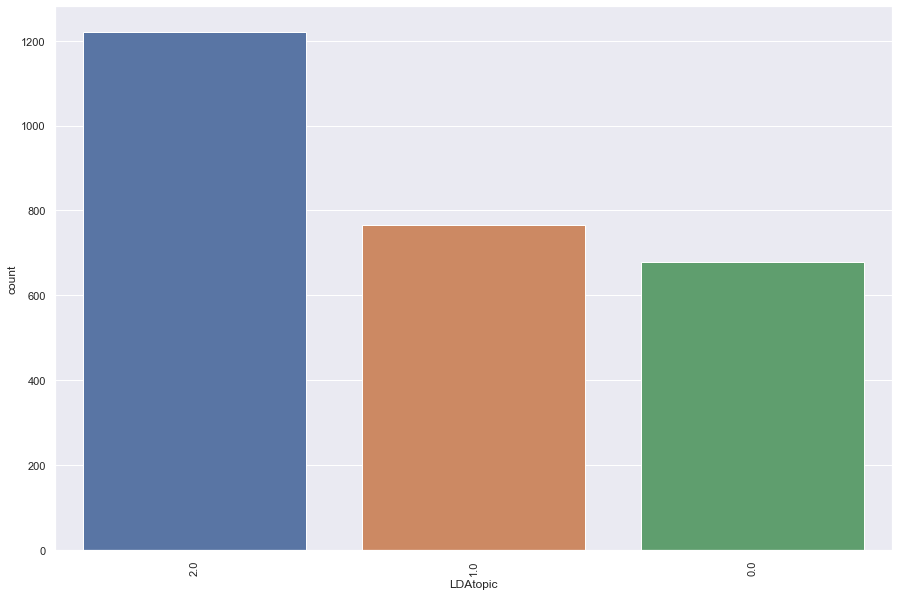

In [34]:
# the distributions of LDA assigned topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='LDAtopic', data=train_df, order = train_df['LDAtopic'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [35]:
# Resort the dataframe according to the the lda assigned topic and the assocoiated probability
train_df.sort_values(['LDAtopic', 'LDAprob'], ascending=[True, False], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
429,relationships,"[broke, contact, whole, family, sparingly, spe...",-0.000595,social,Negative,0.0,0.9979788064956665
1636,assistance,"[thus, counterproductive, work, better, job, t...",0.251984,financial,Positive,0.0,0.9977102875709534
1550,ptsd,"[requested, accommodations, university, willin...",0.187500,PTSD,Positive,0.0,0.9976903796195984
2209,stress,"[responses, survey, items, anonymous, kept, co...",0.100000,anxiety,Positive,0.0,0.9971237182617188
952,relationships,"[fast, forward, tired, rather, leave, convenie...",0.120000,social,Positive,0.0,0.9969218373298645
1085,relationships,"[work, sister, sister, great, job, firm, intro...",0.402857,social,Positive,0.0,0.9965851306915283
1679,anxiety,"[anxiety, year, seventeen, diagnosed, properly...",0.006667,anxiety,Positive,0.0,0.996536135673523
347,anxiety,"[life, spiralled, area, sure, survive, longer,...",-0.064595,anxiety,Negative,0.0,0.9964865446090698
511,ptsd,"[used, sleeping, pills, anti, anxiety, medicin...",0.559091,PTSD,Positive,0.0,0.9964332580566406
1862,relationships,"[girlfriend, real, problems, past, month, enjo...",0.181349,social,Positive,0.0,0.9964332580566406


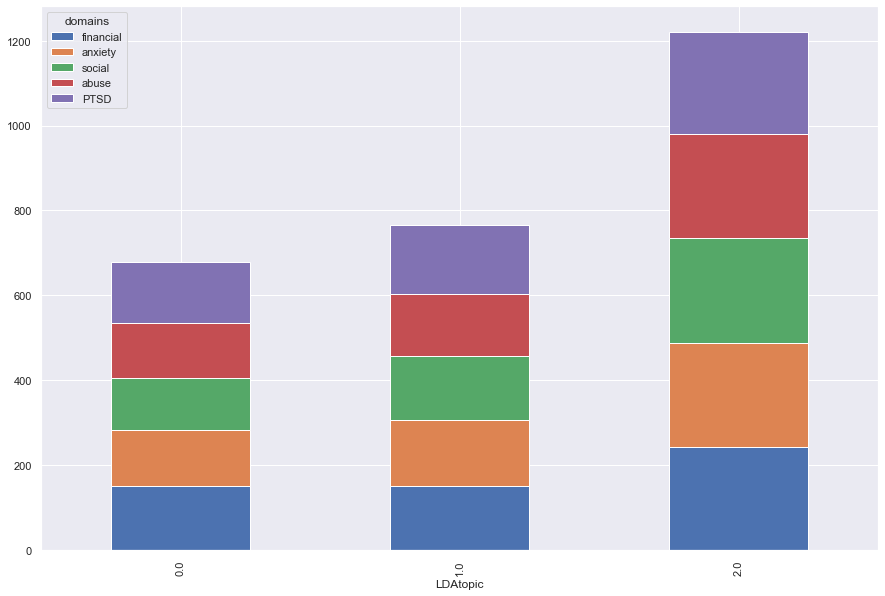

In [36]:
# the topic distrubtions related to the original human annotated/tagged topics
df = train_df.groupby(['LDAtopic', 'domains'])['LDAtopic'].count().unstack('domains')
topic_mixture = df[stress_domains].plot(kind='bar', stacked=True, legend = True)

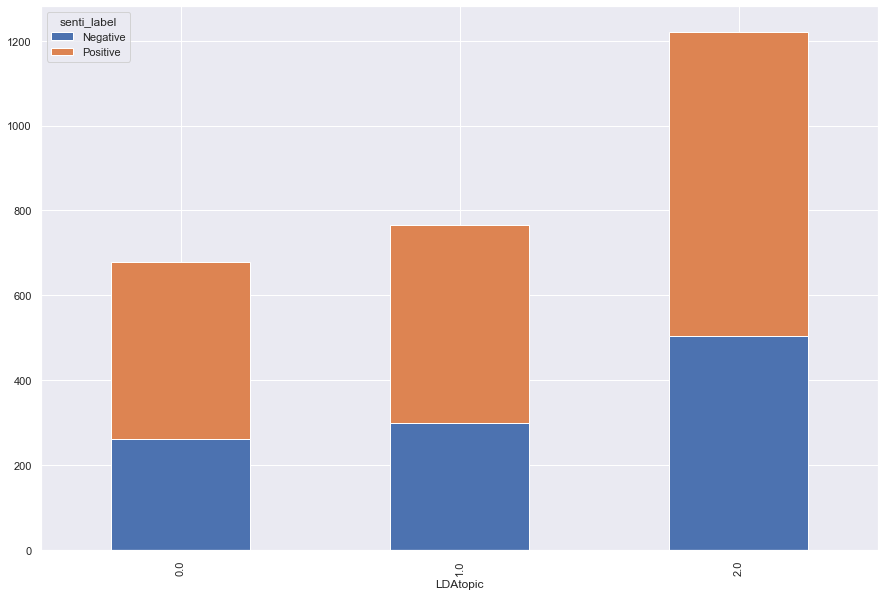

In [37]:
#  the topic distrubtions related to the original human annotated/tagged sentiment
human_sentiment = list(set(train_df['senti_label'].tolist()))
df2 = train_df.groupby(['LDAtopic', 'senti_label'])['LDAtopic'].count().unstack('senti_label')
topic_mixture = df2[human_sentiment].plot(kind='bar', stacked=True, legend = True)

In [38]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.021794 -0.052436       1        1  37.471886
2     -0.038599  0.043534       2        1  34.341152
1      0.060393  0.008902       3        1  28.186953, topic_info=           Term        Freq       Total Category  logprob  loglift
75       survey  113.000000  113.000000  Default  30.0000  30.0000
297      people  407.000000  407.000000  Default  29.0000  29.0000
897   treatment   98.000000   98.000000  Default  28.0000  28.0000
1224      tired   95.000000   95.000000  Default  27.0000  27.0000
113        time  667.000000  667.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
498         ago   52.809959  172.002716   Topic3  -6.0733   0.0855
313        home   54.206833  203.261200   Topic3  -6.0472  -0.0554
135      family   57.876404  248.204437   Topic3  -5.9817  -0.1896
67        right   52.337967  219.002716   Topic3  -6.0822  -0.1651
214    together   48.148869  157.765381   Topic3  -6.1657   0.0795

[274 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3946      1  0.079939   abuses
3946      2  0.879324   abuses
3946      3  0.079939   abuses
7275      1  0.943035  abusing
7275      2  0.067360  abusing
...     ...       ...      ...
862       2  0.125541    write
862       3  0.094156    write
118       1  0.388094     year
118       2  0.316915     year
118       3  0.294884     year

[440 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

When there are 3 topics in this corpus, these topic clusters achieve the furthest distances, 
indicating the distinguishing differences between these topics.

According to LIWC Dictionary:
